In [1]:
import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import numpy as np

from graphnet.models.data_representation.graphs.nodes.nodes import NodesAsPulses

/home/kbas/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


graphnet [MainProcess] WARNING  2025-12-10 13:41:38 - <module> - `jammy_flows` not available. Normalizing Flow functionality is missing.


In [2]:
# ============================================================
# 0. Config
# ============================================================

PULSES_PATH = "/project/def-nahee/kbas/pone_parquet/pulses_batch_3240.parquet"
TRUTH_PATH  = "/project/def-nahee/kbas/pone_parquet/truth_batch_3240.parquet"

# Node features: each row = one pulse
FEATURE_COLS = ["om_x", "om_y", "om_z", "time", "charge"]

# Event ID columns (to group pulses and join truth)
GROUP_COLS = ["run_id", "sub_run_id", "event_id", "sub_event_id"]

# k for k-NN graph (in 3D OM position space)
K_NEIGHBORS = 16

# ============================================================
# 1. Load data
# ============================================================

pulses = pd.read_parquet(PULSES_PATH)
truth  = pd.read_parquet(TRUTH_PATH)

print("Pulses shape:", pulses.shape)
print("Truth shape :", truth.shape)


# ============================================================
# 2. Node definition: one pulse = one node
# ============================================================

node_def = NodesAsPulses(
    input_feature_names=FEATURE_COLS,
)



Pulses shape: (151402, 13)
Truth shape : (34, 14)
graphnet [MainProcess] INFO     2025-12-10 13:41:48 - NodesAsPulses.__init__ - Writing log to logs/graphnet_20251210-134148.log


In [3]:
# ============================================================
# 3. Simple k-NN edge builder (no torch-cluster)
# ============================================================

def build_knn_edges(coords: torch.Tensor, k: int) -> torch.Tensor:
    """
    Build an undirected k-NN graph based on 3D coordinates.

    Args:
        coords: Tensor of shape [N, 3] with (om_x, om_y, om_z).
        k: number of nearest neighbours per node.

    Returns:
        edge_index: LongTensor of shape [2, E].
    """
    N = coords.size(0)

    if N == 0:
        return torch.empty((2, 0), dtype=torch.long)

    if N == 1:
        idx = torch.arange(1, dtype=torch.long)
        return torch.stack([idx, idx], dim=0)

    # Pairwise distance matrix [N, N]
    dist = torch.cdist(coords, coords)

    # For each node: indices of k nearest neighbours (excluding itself)
    k_neigh = min(k, N - 1)
    knn = dist.topk(k_neigh + 1, largest=False).indices[:, 1:]  # [N, k_neigh]

    src = torch.arange(N, dtype=torch.long).repeat_interleave(k_neigh)  # [N*k]
    tgt = knn.reshape(-1)                                               # [N*k]

    edge_index = torch.stack([src, tgt], dim=0)  # [2, E]
    edge_index = to_undirected(edge_index, num_nodes=N)

    return edge_index



In [4]:
# ============================================================
# 4. Build one graph per event
# ============================================================

graphs = []

for event_id, df_evt in pulses.groupby(GROUP_COLS):
    # --- node features ---
    x_np = df_evt[FEATURE_COLS].to_numpy()
    x = torch.tensor(x_np, dtype=torch.float32)         # [num_pulses, 5]
    x = node_def(x)                                     # NodesAsPulses: identity

    data = Data(x=x)

    # --- edges (k-NN in OM position space) ---
    coords = x[:, :3]                                   # (om_x, om_y, om_z)
    data.edge_index = build_knn_edges(coords, k=K_NEIGHBORS)

    # --- match truth row for this event ---
    run, sub_run, evt, sub_evt = event_id
    mask = (
        (truth["run_id"] == run) &
        (truth["sub_run_id"] == sub_run) &
        (truth["event_id"] == evt) &
        (truth["sub_event_id"] == sub_evt)
    )
    row = truth.loc[mask].iloc[0]

    # Main regression label: totalEnergy
    data.y = torch.tensor([row["totalEnergy"]], dtype=torch.float32)

    # Extra labels as attributes (for plotting / later use)
    data.zenith  = float(row["zenith"])
    data.azimuth = float(row["azimuth"])
    data.vertex  = torch.tensor([row["x"], row["y"], row["z"]], dtype=torch.float32)
    data.initial_type = int(row["initialType"])
    data.final_type1  = int(row["finalType1"])
    data.final_type2  = int(row["finalType2"])
    data.batch_id     = int(row["batch_id"])

    graphs.append(data)

print(f"\nNumber of event graphs: {len(graphs)}")
if graphs:
    g0 = graphs[0]
    print("First graph:", g0)
    print("  x shape       :", g0.x.shape)
    print("  edge_index shape:", g0.edge_index.shape)
    print("  y (totalEnergy):", g0.y.item())




Number of event graphs: 34
First graph: Data(x=[4485, 5], edge_index=[2, 84105], y=[1], zenith=1.9976308307953075, azimuth=0.04651655392118388, vertex=[3], initial_type=14, final_type1=13, final_type2=-2000001006, batch_id=3240)
  x shape       : torch.Size([4485, 5])
  edge_index shape: torch.Size([2, 84105])
  y (totalEnergy): 270.654541015625


In [5]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np


def plot_event_3d(graphs, event_index: int = 0, max_edges: int = 2000):
    """
    Plot a 3D kNN graph for a single event.

    Parameters
    ----------
    graphs : list[torch_geometric.data.Data]
        List of event graphs.
    event_index : int
        Index of the event in `graphs` to plot.
    max_edges : int
        Maximum number of edges to draw (to avoid clutter).
    """
    if not graphs:
        raise ValueError("graphs list is empty.")

    if event_index < 0 or event_index >= len(graphs):
        raise IndexError(
            f"event_index {event_index} is out of range "
            f"(0..{len(graphs) - 1})"
        )

    g = graphs[event_index]

    # ---- node positions and features ----
    coords = g.x[:, :3].cpu().numpy()        # (om_x, om_y, om_z)
    edge_index = g.edge_index.cpu().numpy()

    x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]
    time = g.x[:, 3].cpu().numpy()          # use time as color

    # ---- event-level labels ----
    total_energy = float(g.y.item())

    # angles are stored in RADIANS in your data
    zenith_rad = float(g.zenith)
    azimuth_rad = float(g.azimuth)

    # for display only
    zenith_deg = np.rad2deg(zenith_rad)
    azimuth_deg = np.rad2deg(azimuth_rad)

    vx, vy, vz = g.vertex.cpu().numpy().tolist()
    initial_type = g.initial_type
    final_type1 = g.final_type1
    final_type2 = g.final_type2
    batch_id = g.batch_id

    # ---- figure and scatter plot ----
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection="3d")

    scatter = ax.scatter(x, y, z, s=5, c=time, alpha=0.8)
    cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
    cbar.set_label("time", rotation=270, labelpad=15)

    # ---- edges (subset) ----
    E = edge_index.shape[1]
    use_E = min(E, max_edges)

    for i in range(use_E):
        s = edge_index[0, i]
        t = edge_index[1, i]
        ax.plot(
            [x[s], x[t]],
            [y[s], y[t]],
            [z[s], z[t]],
            linewidth=0.3,
            alpha=0.15,
        )

    # ---- true vertex ----
    ax.scatter(
        [vx], [vy], [vz],
        s=80,
        marker="x",
        color="red",
        label="true vertex",
    )

    # ---- true direction (using radians) ----
    dx = np.sin(zenith_rad) * np.cos(azimuth_rad)
    dy = np.sin(zenith_rad) * np.sin(azimuth_rad)
    dz = np.cos(zenith_rad)

    L = 300.0  # arrow length scale
    ax.quiver(
        vx, vy, vz,
        dx * L, dy * L, dz * L,
        color="red",
        linewidth=2.0,
        arrow_length_ratio=0.1,
        label="true direction",
    )

    # ---- axes, title, legend ----
    ax.set_xlabel("om_x")
    ax.set_ylabel("om_y")
    ax.set_zlabel("om_z")
    ax.set_title(f"3D kNN graph for one event (index {event_index})")
    ax.view_init(elev=20, azim=40)
    ax.legend(loc="upper left")

    # ---- labels at the bottom ----
    label_text = (
        f"batch_id={batch_id}   "
        f"totalEnergy={total_energy:.2e}   "
        f"zenith={zenith_rad:.3f} rad ({zenith_deg:.1f}°)   "
        f"azimuth={azimuth_rad:.3f} rad ({azimuth_deg:.1f}°)   "
        f"vertex=({vx:.1f}, {vy:.1f}, {vz:.1f})   "
        f"initialType={initial_type}   "
        f"finalType1={final_type1}   "
        f"finalType2={final_type2}"
    )

    fig.text(0.5, 0.02, label_text, ha="center", va="bottom", fontsize=9)
    plt.tight_layout(rect=(0, 0.05, 1, 1))
    plt.show()


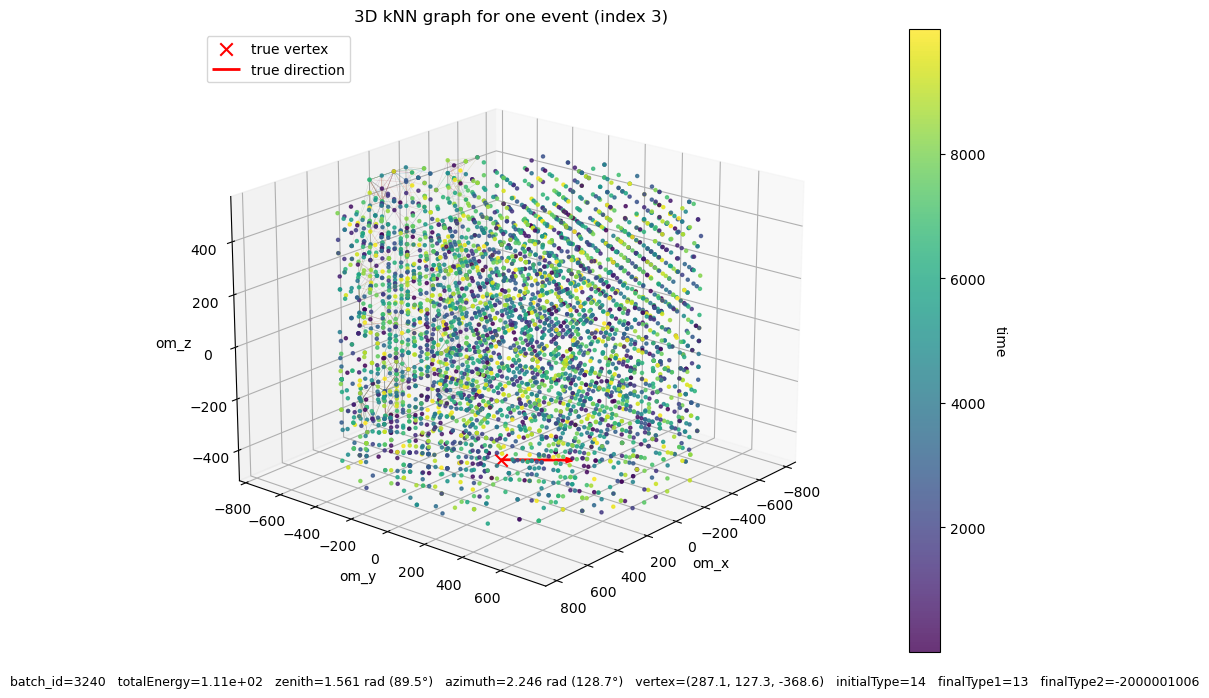

In [6]:
plot_event_3d(graphs, event_index=3)


In [7]:
# bu plotlari class yapisina cevir. batch id event id vs alinca cizsin direkt

In [8]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np


def plot_event_3d_zoomed_local(graphs, event_index: int = 0,
                               box_size: float = 300.0,
                               max_edges: int = 5000):
    """
    Plot a zoomed 3D kNN graph around the true vertex for a single event.
    Only nodes and edges inside a cube around the vertex are shown.

    Parameters
    ----------
    graphs : list[Data]
        List of event graphs.
    event_index : int
        Index of the event in `graphs` to plot.
    box_size : float
        Half-size of the cube around the vertex in each axis.
        Region: [vx±box_size, vy±box_size, vz±box_size].
    max_edges : int
        Maximum number of edges to consider (after filtering).
    """
    if not graphs:
        raise ValueError("graphs list is empty.")
    if event_index < 0 or event_index >= len(graphs):
        raise IndexError(
            f"event_index {event_index} is out of range "
            f"(0..{len(graphs) - 1})"
        )

    g = graphs[event_index]

    # --- all node positions and features ---
    coords_all = g.x[:, :3].cpu().numpy()        # (om_x, om_y, om_z)
    x_all, y_all, z_all = coords_all[:, 0], coords_all[:, 1], coords_all[:, 2]
    time_all = g.x[:, 3].cpu().numpy()

    edge_index_all = g.edge_index.cpu().numpy()

    # --- event-level labels ---
    total_energy = float(g.y.item())
    zenith_rad = float(g.zenith)
    azimuth_rad = float(g.azimuth)
    zenith_deg = np.rad2deg(zenith_rad)
    azimuth_deg = np.rad2deg(azimuth_rad)

    vx, vy, vz = g.vertex.cpu().numpy().tolist()
    initial_type = g.initial_type
    final_type1 = g.final_type1
    final_type2 = g.final_type2
    batch_id = g.batch_id

    # --- mask: keep only nodes inside cube around vertex ---
    mask_nodes = (
        (x_all >= vx - box_size) & (x_all <= vx + box_size) &
        (y_all >= vy - box_size) & (y_all <= vy + box_size) &
        (z_all >= vz - box_size) & (z_all <= vz + box_size)
    )

    # coordinates and times for zoomed region
    x = x_all[mask_nodes]
    y = y_all[mask_nodes]
    z = z_all[mask_nodes]
    time = time_all[mask_nodes]

    # we still use original indices for edges, but only draw edges
    # where BOTH endpoints are inside cube
    edge_index = edge_index_all
    E = edge_index.shape[1]
    use_E = min(E, max_edges)

    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection="3d")

    # --- nodes (only inside cube) ---
    scatter = ax.scatter(x, y, z, s=5, c=time, alpha=0.8)
    cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
    cbar.set_label("time", rotation=270, labelpad=15)

    # --- edges: only edges fully inside cube ---
    for i in range(use_E):
        s = edge_index[0, i]
        t = edge_index[1, i]
        if mask_nodes[s] and mask_nodes[t]:
            ax.plot(
                [x_all[s], x_all[t]],
                [y_all[s], y_all[t]],
                [z_all[s], z_all[t]],
                linewidth=0.3,
                alpha=0.2,
            )

    # --- true vertex ---
    ax.scatter(
        [vx], [vy], [vz],
        s=80,
        marker="x",
        color="red",
        label="true vertex",
    )

    # --- true direction ---
    dx = np.sin(zenith_rad) * np.cos(azimuth_rad)
    dy = np.sin(zenith_rad) * np.sin(azimuth_rad)
    dz = np.cos(zenith_rad)

    L = box_size  # arrow length comparable to zoom size
    ax.quiver(
        vx, vy, vz,
        dx * L, dy * L, dz * L,
        color="red",
        linewidth=2.0,
        arrow_length_ratio=0.1,
        label="true direction",
    )

    # --- axis limits exactly match zoom cube ---
    ax.set_xlim(vx - box_size, vx + box_size)
    ax.set_ylim(vy - box_size, vy + box_size)
    ax.set_zlim(vz - box_size, vz + box_size)

    ax.set_xlabel("om_x")
    ax.set_ylabel("om_y")
    ax.set_zlabel("om_z")
    ax.set_title(f"Zoomed 3D kNN graph (local) for event index {event_index}")
    ax.view_init(elev=20, azim=40)
    ax.legend(loc="upper left")

    # --- labels at the bottom ---
    label_text = (
        f"batch_id={batch_id}   "
        f"totalEnergy={total_energy:.2e}   "
        f"zenith={zenith_rad:.3f} rad ({zenith_deg:.1f}°)   "
        f"azimuth={azimuth_rad:.3f} rad ({azimuth_deg:.1f}°)   "
        f"vertex=({vx:.1f}, {vy:.1f}, {vz:.1f})   "
        f"initialType={initial_type}   "
        f"finalType1={final_type1}   "
        f"finalType2={final_type2}"
    )

    fig.text(0.5, 0.02, label_text, ha="center", va="bottom", fontsize=9)
    plt.tight_layout(rect=(0, 0.05, 1, 1))
    plt.show()


<IPython.core.display.Javascript object>


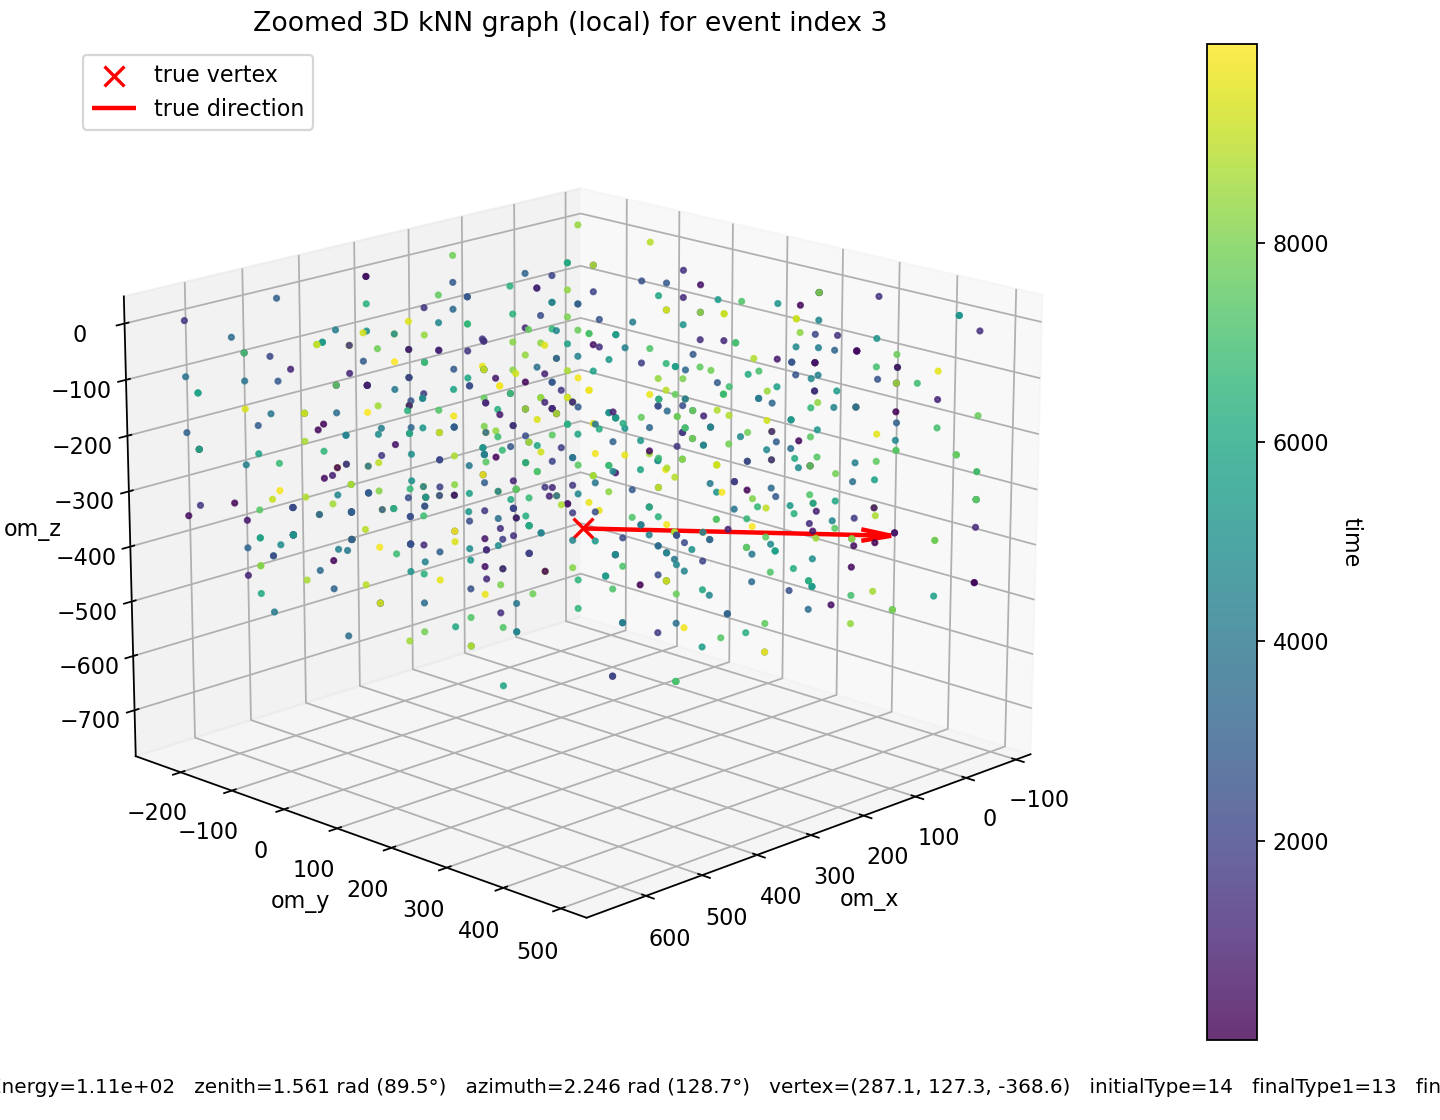

In [15]:
plot_event_3d_zoomed_local(graphs, event_index=3, box_size=400.0)


In [10]:
%matplotlib notebook
# %matplotlib widget


<IPython.core.display.Javascript object>


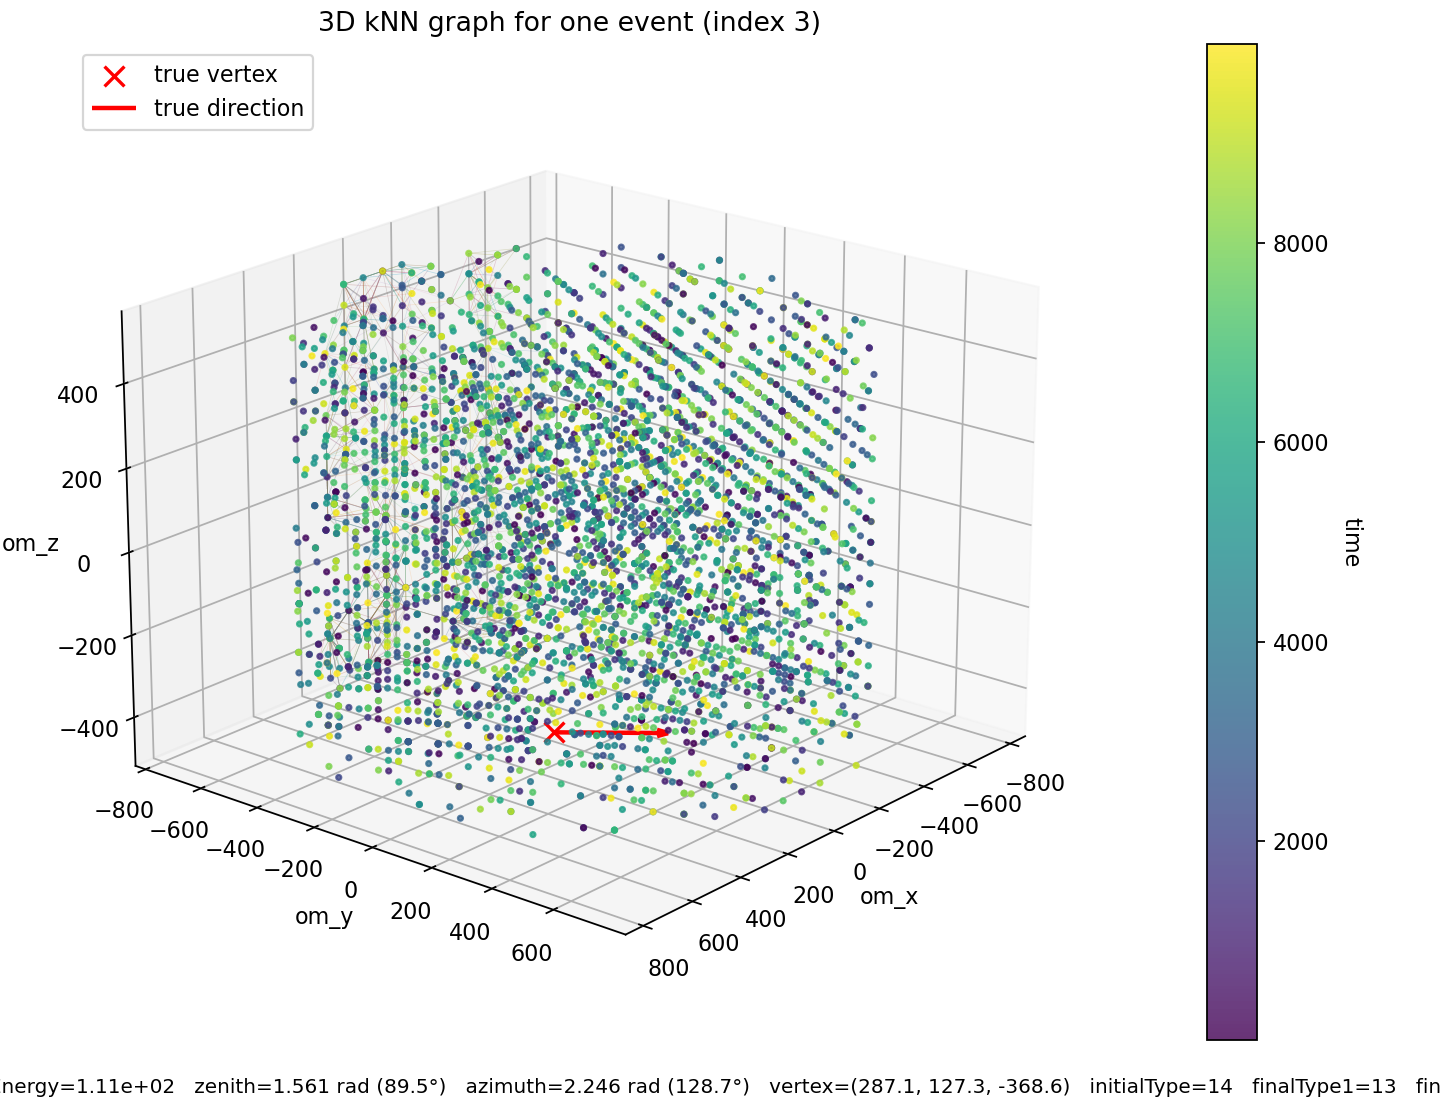

In [14]:
plot_event_3d(graphs, event_index=3)

In [36]:
"""Class(es) implementing layers to be used in `graphnet` models."""

from typing import Any, Callable, Optional, Sequence, Union, List

import torch
import torch.nn as nn
from torch.functional import Tensor
from torch_geometric.nn import EdgeConv
from torch_geometric.nn.pool import (
    knn_graph,
    global_mean_pool,
    global_add_pool,
)
from torch_geometric.typing import Adj, PairTensor
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.inits import reset
from torch_geometric.data import Data
from torch.nn.functional import linear
from torch.nn.modules import TransformerEncoder, TransformerEncoderLayer
from torch_geometric.utils import to_dense_batch, softmax
from torch_scatter import scatter

from pytorch_lightning import LightningModule


class DynEdgeConv(EdgeConv, LightningModule):
    """Dynamical edge convolution layer."""

    def __init__(
        self,
        nn: Callable,
        aggr: str = "max",
        nb_neighbors: int = 8,
        features_subset: Optional[Union[Sequence[int], slice]] = None,
        **kwargs: Any,
    ):
        """Construct `DynEdgeConv`.

        Args:
            nn: The MLP/torch.Module to be used within the `EdgeConv`.
            aggr: Aggregation method to be used with `EdgeConv`.
            nb_neighbors: Number of neighbours to be clustered after the
                `EdgeConv` operation.
            features_subset: Subset of features in `Data.x` that should be used
                when dynamically performing the new graph clustering after the
                `EdgeConv` operation. Defaults to all features.
            **kwargs: Additional features to be passed to `EdgeConv`.
        """
        # Check(s)
        if features_subset is None:
            features_subset = slice(None)  # Use all features
        assert isinstance(features_subset, (list, slice))

        # Base class constructor
        super().__init__(nn=nn, aggr=aggr, **kwargs)

        # Additional member variables
        self.nb_neighbors = nb_neighbors
        self.features_subset = features_subset

    def forward(
        self, x: Tensor, edge_index: Adj, batch: Optional[Tensor] = None
    ) -> Tensor:
        """Forward pass.

        NOT: torch-cluster kullanmıyoruz, o yüzden adjacency'yi
        yeniden hesaplamıyoruz; verilen edge_index'i aynen kullanıyoruz.
        """
        # EdgeConv ile node feature'larını güncelle
        x = super().forward(x, edge_index)

        # Dynamic k-NN YOK → edge_index değişmeden geri dönüyor
        return x, edge_index



In [37]:
import torch
import torch.nn as nn
from torch_geometric.nn import global_mean_pool

class DynEdgeEnergyNet(nn.Module):
    def __init__(self, in_channels: int = 5, hidden: int = 128, nb_neighbors: int = 16):
        super().__init__()

        # 1. DynEdgeConv katmanı
        self.conv1 = DynEdgeConv(
            nn=nn.Sequential(
                nn.Linear(in_channels * 2, hidden),
                nn.ReLU(),
                nn.Linear(hidden, hidden),
                nn.ReLU(),
            ),
            aggr="max",
            nb_neighbors=nb_neighbors,
            features_subset=slice(None),
        )

        # 2. DynEdgeConv katmanı
        self.conv2 = DynEdgeConv(
            nn=nn.Sequential(
                nn.Linear(hidden * 2, hidden),
                nn.ReLU(),
                nn.Linear(hidden, hidden),
                nn.ReLU(),
            ),
            aggr="max",
            nb_neighbors=nb_neighbors,
            features_subset=slice(None),
        )

        # graph-level (event-level) regresyon başı
        self.head = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),   # totalEnergy
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # senin DynEdgeConv'un **(x, edge_index)** döndürüyor
        x, edge_index = self.conv1(x, edge_index, batch=batch)
        x, edge_index = self.conv2(x, edge_index, batch=batch)

        # node → graph pool
        g = global_mean_pool(x, batch)   # [num_graphs, hidden]

        out = self.head(g).squeeze(-1)   # [num_graphs]
        return out


In [38]:
import pandas as pd
from pathlib import Path

# 1. CSV'yi oku ve karıştır
all_events_path = "/project/def-nahee/kbas/Graphnet-Applications/all_events.csv"
all_events_df = pd.read_csv(all_events_path)

# Veriyi karıştır
all_events_df = all_events_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Train/Val/Test olarak ayır
train_end = int(0.8 * len(all_events_df))
val_end = train_end + int(0.1 * len(all_events_df))

train_df = all_events_df.iloc[:train_end]
val_df = all_events_df.iloc[train_end:val_end]
test_df = all_events_df.iloc[val_end:]




In [39]:
def load_event(batch_id, run_id, sub_run_id, event_id, sub_event_id):
    # Batch_id ile dosya yolunu bul
    batch_file = f"/project/def-nahee/kbas/pone_parquet/pulses_batch_{batch_id}.parquet"
    pulses_df = pd.read_parquet(batch_file)
    
    # Diğer kimliklerle filtrele
    event_data = pulses_df[
        (pulses_df['run_id'] == run_id) &
        (pulses_df['sub_run_id'] == sub_run_id) &
        (pulses_df['event_id'] == event_id) &
        (pulses_df['sub_event_id'] == sub_event_id)
    ]
    
    return event_data

In [40]:
example = train_df.iloc[0]
event_data = load_event(
    batch_id=example['batch_id'],
    run_id=example['run_id'],
    sub_run_id=example['sub_run_id'],
    event_id=example['event_id'],
    sub_event_id=example['sub_event_id']
)

print(event_data)

        run_id  sub_run_id  event_id  sub_event_id  string_id  om_id  pmt_id  \
98217     3494  4294967295       107             0          1      1       8   
98218     3494  4294967295       107             0          1      1      16   
98219     3494  4294967295       107             0          1      1      16   
98220     3494  4294967295       107             0          1      3       4   
98221     3494  4294967295       107             0          1      4       6   
...        ...         ...       ...           ...        ...    ...     ...   
102725    3494  4294967295       107             0        340      6      13   
102726    3494  4294967295       107             0        340     14       5   
102727    3494  4294967295       107             0        340     17       2   
102728    3494  4294967295       107             0        340     17       3   
102729    3494  4294967295       107             0        340     20      12   

               time    charge   om_x   

In [41]:
# device = torch.device("cuda")

In [42]:
import torch
import torch.nn as nn
import numpy as np
from torch_geometric.loader import DataLoader

# 1) Cihaz
device = torch.device("cpu")
print("device:", device)


# 2) Model (senin DynEdgeEnergyNet'in)
model = DynEdgeEnergyNet(
    in_channels=graphs[0].x.size(1),  # muhtemelen 5
    hidden=128,
    nb_neighbors=16,
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 3) 100 tane event seç (veya elinde daha az varsa hepsini al)
num_graphs = len(graphs)
n_subset = min(100, num_graphs)

perm = np.random.permutation(num_graphs)[:n_subset]
subset = [graphs[i] for i in perm]

# 80 / 10 / 10 split
n_train = int(0.8 * n_subset)
n_val   = int(0.1 * n_subset)
n_test  = n_subset - n_train - n_val

train_graphs = subset[:n_train]
val_graphs   = subset[n_train:n_train + n_val]
test_graphs  = subset[n_train + n_val : n_subset]

print(f"using {n_train} train, {len(val_graphs)} val, {len(test_graphs)} test graphs")

# 4) DataLoader'lar — HİÇ collate_fn yok artık, çünkü zaten Data objeleri
train_loader = DataLoader(train_graphs, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_graphs,   batch_size=16, shuffle=False)
test_loader  = DataLoader(test_graphs,  batch_size=16, shuffle=False)

# 5) Train / eval fonksiyonları

def train_one_epoch(loader):
    model.train()
    total_loss = 0.0
    total_graphs = 0

    for batch_idx, batch in enumerate(loader):
        batch = batch.to(device)

        pred = model(batch)              # [batch_size]
        target = batch.y.view(-1)        # [batch_size]

        loss = criterion(pred, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch.num_graphs
        total_graphs += batch.num_graphs

        # hangi batch'teyiz, loss kaç
        print(f"  batch {batch_idx:03d} | loss = {loss.item():.4e}")

    return total_loss / total_graphs


@torch.no_grad()
def evaluate(loader):
    model.eval()
    total_loss = 0.0
    total_graphs = 0

    for batch in loader:
        batch = batch.to(device)
        pred = model(batch)
        target = batch.y.view(-1)
        loss = criterion(pred, target)

        total_loss += loss.item() * batch.num_graphs
        total_graphs += batch.num_graphs

    return total_loss / total_graphs

# 6) Birkaç epoch mini-training
for epoch in range(1, 6):
    print(f"\nEpoch {epoch}")
    train_loss = train_one_epoch(train_loader)
    val_loss   = evaluate(val_loader)
    print(f"Epoch {epoch}: train MSE = {train_loss:.4e} | val MSE = {val_loss:.4e}")

test_loss = evaluate(test_loader)
print(f"\nFinal test MSE = {test_loss:.4e}")


device: cpu
using 27 train, 3 val, 4 test graphs

Epoch 1
  batch 000 | loss = 8.3295e+06
  batch 001 | loss = 7.2348e+06
Epoch 1: train MSE = 7.8835e+06 | val MSE = 3.5759e+06

Epoch 2
  batch 000 | loss = 3.7836e+06
  batch 001 | loss = 1.2209e+07
Epoch 2: train MSE = 7.2163e+06 | val MSE = 2.9778e+06

Epoch 3
  batch 000 | loss = 6.2197e+06
  batch 001 | loss = 6.5533e+06
Epoch 3: train MSE = 6.3556e+06 | val MSE = 2.4301e+06

Epoch 4
  batch 000 | loss = 6.8711e+06
  batch 001 | loss = 4.3625e+06
Epoch 4: train MSE = 5.8491e+06 | val MSE = 2.8454e+06

Epoch 5
  batch 000 | loss = 7.0683e+06
  batch 001 | loss = 4.1315e+06
Epoch 5: train MSE = 5.8718e+06 | val MSE = 3.1832e+06

Final test MSE = 2.9994e+06


In [43]:
batch = next(iter(test_loader))
batch = batch.to(device)

with torch.no_grad():
    pred = model(batch)          # tahminler [num_graphs]
    true = batch.y.view(-1)      # gerçek totalEnergy

print("true energies :", true.cpu().numpy())
print("pred energies :", pred.cpu().numpy())
print("diff (pred-true):", (pred-true).cpu().numpy())


true energies : [ 353.44727  147.97928 2048.1355  4418.0874 ]
pred energies : [2025.043  2193.536  2194.047  2182.5178]
diff (pred-true): [ 1671.5957   2045.5566    145.91162 -2235.5696 ]
